## Assignment: predicting house prices

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

* Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

```python
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
```

* Please follow the example above and call `engine.dispose()` when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.


# Goals:

- Clean the data
- Find useful variables for predicting house prices
- Build a model and estimate parameters with OLS

In [1]:
# Loading the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

**Data Exploration**

In [3]:
# Loading the dataset:
house_prices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
house_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

The dataset contains 1460 observations and 81 columns in total. There are numeric(int and float) and non-numeric attributes in our dataset. 

It is also clear that not all features contain the same amount of rows. This could possibly be due to missing values and outliers in our dataset.

Since 'saleprice is our target variable, let's visualize the shape of the distribution theough a histogram. 

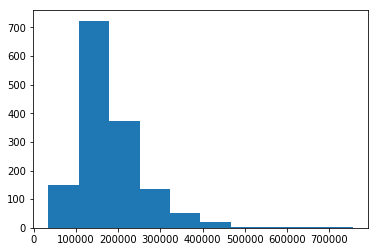

In [6]:
# Let's visualize the data:
plt.hist(house_prices.saleprice)
plt.show()

We have a right skewed distribution for sales price, which means that our mean for sales price is greater than the median of the distribution.

Let's now detect the problems in out dataset. For this purpose, I will use the .isnull() function to detect our null values.

In [12]:
# Finding Missing values in the dataset:
missing_sum = house_prices.isnull().sum().sort_values(ascending=False)

# Finding the percentage of missing values:
missing_percent = (house_prices.isnull().sum()/house_prices.isnull().count()).sort_values(ascending=False)

# Missing values:
missing_values = pd.concat([missing_sum, missing_percent], axis=1, keys=['Total', 'Percent'])
missing_values.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


We have 19 features with missing values, most of which are housing extras that may not significantly correlate with SalePrice. Let's draw a correlation table to find out the correlation of the features:

In [16]:
house_prices.corr().sort_values(by='saleprice',ascending=False)

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
saleprice,-0.021917,-0.084284,0.351799,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,0.386420,...,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,0.046432,-0.028923,1.000000
overallqual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
grlivarea,0.008273,0.074853,0.402797,0.263116,0.593007,-0.079686,0.199010,0.287389,0.390857,0.208171,...,0.247433,0.330224,0.009113,0.020643,0.101510,0.170205,-0.002416,0.050240,-0.036526,0.708624
garagecars,0.016570,-0.040110,0.285691,0.154871,0.600671,-0.185758,0.537850,0.420622,0.364204,0.224054,...,0.226342,0.213569,-0.151434,0.035765,0.050494,0.020934,-0.043080,0.040522,-0.039117,0.640409
garagearea,0.017634,-0.098672,0.344997,0.180403,0.562022,-0.151521,0.478954,0.371600,0.373066,0.296970,...,0.224666,0.241435,-0.121777,0.035087,0.051412,0.061047,-0.027400,0.027974,-0.027378,0.623431
totalbsmtsf,-0.015415,-0.238518,0.392075,0.260833,0.537808,-0.171098,0.391452,0.291066,0.363936,0.522396,...,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969,0.613581
firstflrsf,0.010496,-0.251758,0.457181,0.299475,0.476224,-0.144203,0.281986,0.240379,0.344501,0.445863,...,0.235459,0.211671,-0.065292,0.056104,0.088758,0.131525,-0.021096,0.031372,-0.013604,0.605852
fullbath,0.005587,0.131608,0.198769,0.126031,0.550600,-0.194149,0.468271,0.439046,0.276833,0.058543,...,0.187703,0.259977,-0.115093,0.035353,-0.008106,0.049604,-0.014290,0.055872,-0.019669,0.560664
totrmsabvgrd,0.027239,0.040380,0.352096,0.190015,0.427452,-0.057583,0.095589,0.191740,0.280682,0.044316,...,0.165984,0.234192,0.004151,-0.006683,0.059383,0.083757,0.024763,0.036907,-0.034516,0.533723
yearbuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897


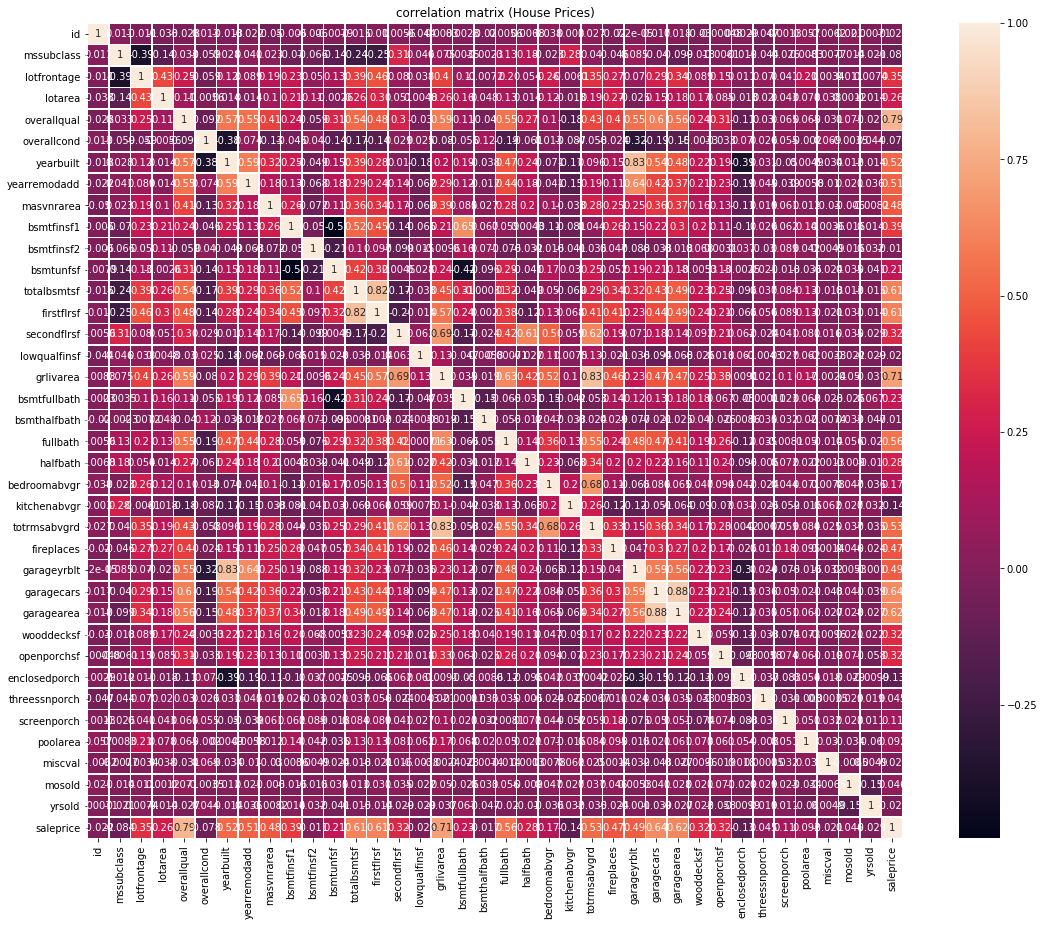

In [20]:
import seaborn as sns

# make the correlation matrix.
corr_houses = house_prices.corr()

plt.figure(figsize=(20,15))

# draw the heatmap using seaborn.
sns.heatmap(corr_houses, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (House Prices)")

plt.show()

Here we notice that 'yearbuilt' strongly correlate to 'garageyrblt'. Other highly correlating variables include:
-  'totrmsabvgrd' and 'grlivarea'

During our data exploration phase, we noticed categorical variables in our dataset. These categorical variables should be converted into numerical values. For this purpose, let's use Pandas .get_dummies() function to create a separate binary variable which takes 1 or 0 for each of the unique value of the categorical variable. 

In [21]:
house_prices = pd.concat([house_prices,pd.get_dummies(house_prices.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices = pd.concat([house_prices,pd.get_dummies(house_prices.street, prefix="street", drop_first=True)], axis=1)
dummy_cols = list(pd.get_dummies(house_prices.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_cols = dummy_cols + list(pd.get_dummies(house_prices.street, prefix="street", drop_first=True).columns)

# Regression Model

Here are the variables we will be using for our regression model:

In [24]:
X = house_prices[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_cols]
Y = house_prices.saleprice

In [25]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     482.0
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        13:08:30   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1449   BIC:                         3.503e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.173e+05    1.8e+04     -6.502      0.000   -1.53e+05   -8.19e+04
overallqual  2.333e+04   1088.506     21.430      0.000    2.12e+04    2.55e+04
grlivarea      45.6344      2.468     18.494      0.000      40.794      50.475
garagecars   1.345e+04   2990.453      4.498      0.000    7584.056    1.93e+04
garagearea     16.4082     10.402      1.577      0.115      -3.997      36.813
totalbsmtsf    28.3816      2.931      9.684      0.000      22.633      34.131
mszoning_FV  2.509e+04   1.37e+04      1.833      0.067   -1761.679    5.19e+04
mszoning_RH  1.342e+04   1.58e+04      0.847      0.397   -1.77e+04    4.45e+04
mszoning_RL  2.857e+04   1.27e+04      2.246      0.025    3612.782    5.35e+04
mszoning_RM  9047.7894   1.29e+04      0.702      0.483   -1.62e+04    3.43e+04
street_Pave   151.0376   1.63e+04      0.009      0.993   -3.18e+04    3.21e+04
==============================================================================
Omnibus:                      415.883   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41281.526
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                      29.049   Cond. No.                     5.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""